In [19]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import os
# import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
patch_h = 40
patch_w = 40
feat_dim = 1536 # vitg14

transform = T.Compose([
    T.GaussianBlur(9, sigma=(0.1, 2.0)),
    T.Resize((patch_h * 14, patch_w * 14)),
    T.CenterCrop((patch_h * 14, patch_w * 14)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14').cuda()

print(dinov2_vitg14)


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1): NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise

In [24]:
# extract features
features = torch.zeros(4, patch_h * patch_w, feat_dim)
imgs_tensor = torch.zeros(4, 3, patch_h * 14, patch_w * 14)
for i in range(4):
    img_path = '/notebooks/snake-data/231354732.jpg'
    img = Image.open(img_path).convert('RGB')
    img=TF.adjust_sharpness(img, 20.0)
    imgs_tensor[i] = transform(img)[:3]
with torch.no_grad():
    features_dict = dinov2_vitg14.forward_features(imgs_tensor.cuda())
    features = features_dict['x_norm_patchtokens']

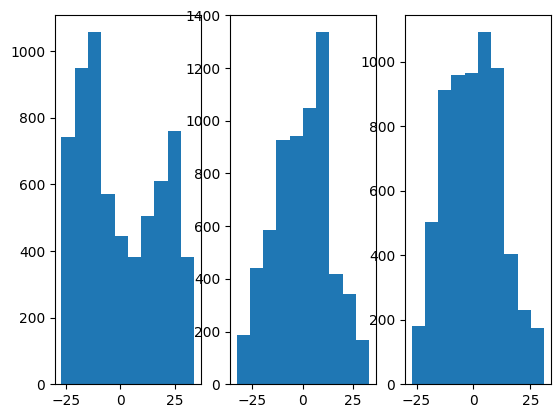

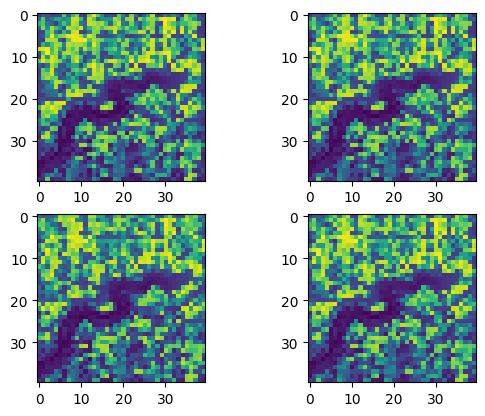

[ True  True  True ...  True  True  True]


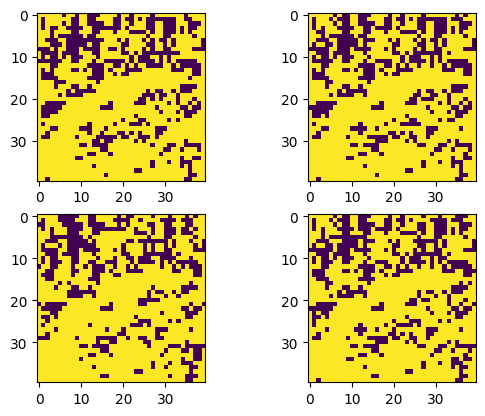

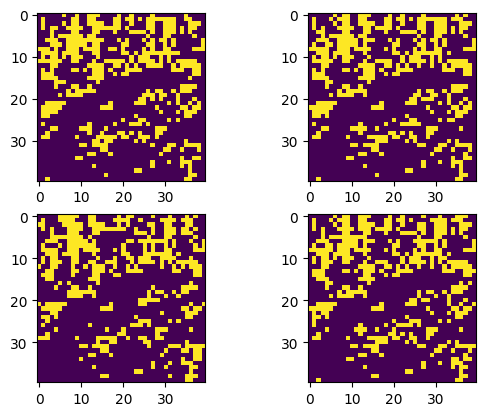

[[ 23.085793   -5.846947  -13.397853 ]
 [-25.839485  -12.378329   -3.2806833]
 [ 25.330326  -14.184509    6.5916204]
 ...
 [ 24.041325   12.9946995  -2.8199532]
 [ 15.993124   10.5787325   0.6542322]
 [ 24.255451    8.743203    2.9868777]]


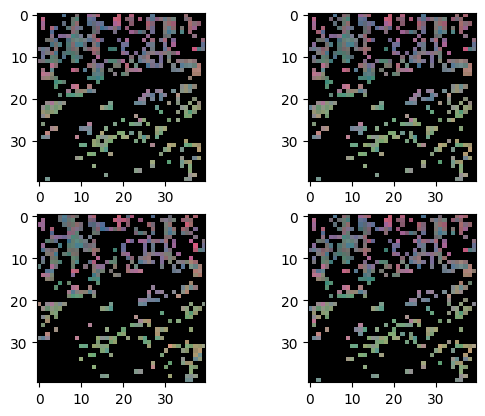

In [27]:
# PCA for feature inferred
from sklearn.decomposition import PCA

features = features.reshape(4 * patch_h * patch_w, feat_dim)

pca = PCA(n_components=3)
pca.fit(features.detach().cpu().numpy())
pca_features = pca.transform(features.detach().cpu().numpy())


plt.subplot(1, 3, 1)
plt.hist(pca_features[:, 0])
plt.subplot(1, 3, 2)
plt.hist(pca_features[:, 1])
plt.subplot(1, 3, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()
plt.savefig('feat.png')
# segment using the first component

# uncomment below to plot the first pca component
pca_features[:, 1] = (pca_features[:, 1] - pca_features[:, 1].min()) / (pca_features[:, 1].max() - pca_features[:, 1].min())
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i * patch_h * patch_w: (i+1) * patch_h * patch_w, 0].reshape(patch_h, patch_w))
plt.show()
plt.close()

pca_features_bg = pca_features[:, 0] < 15
pca_features_fg = ~pca_features_bg
print(pca_features_bg)
# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_fg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()

# PCA for only foreground patches
pca.fit(features[pca_features_fg].detach().cpu().numpy()) # NOTE: I forgot to add it in my original answer
pca_features_rem = pca.transform(features[pca_features_fg].detach().cpu().numpy())
print(pca_features_rem)
for i in range(3):
    # pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].min()) / (pca_features_rem[:, i].max() - pca_features_rem[:, i].min())
    # transform using mean and std, I personally found this transformation gives a better visualization
    pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].mean()) / (pca_features_rem[:, i].std() ** 2) + 0.5

pca_features_rgb = pca_features.copy()
pca_features_rgb[pca_features_bg] = 0
pca_features_rgb[pca_features_fg] = pca_features_rem

pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i][..., ::-1])
plt.savefig('features.png')
plt.show()
plt.close()